In [1]:
import os
root_dir = '/home/yasaisen/Desktop/11_research/11_research_main/lab_03'

In [2]:
# !pip install segmentation-models-pytorch
# !pip install ipywidgets

Import Libraries

In [3]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F

import random
import os, shutil
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import segmentation_models_pytorch as smp

%matplotlib inline

Setup config class

In [4]:
class Config:
    
    data_dir = os.path.join(root_dir, "kaggle_3m/")
    
    validation_fraction = 0.15
    test_fraction = 0.10
    train_batch = 16
    valid_batch = 32
    test_batch = 32
    
    input_dim = 256
    input_ch = 3
    output_dim = 256
    output_ch = 1
    
    seed = 1
    learning_rate = 0.01
    epochs = 30
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Helper Functions

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def plot_example(idx):
    base_path = Config.data_dir+ test_df['directory'].iloc[idx]
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")
    plt.show()

In [6]:
def show_sample(sample, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(sample[0])
    ax[1].imshow(sample[1], cmap="gray")
    if title:
        fig.suptitle(title)
    plt.show()

In [7]:
def plot_predictions(model, idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    tensor_img, tensor_mask = eval_transforms((img, mask))
    tensor_img = tensor_img.unsqueeze(0).to(Config.device)
    
    model.eval()
    
    with torch.no_grad():
        pred = model(tensor_img)[0].detach().cpu().numpy()
        pred = pred.transpose((1,2,0)).squeeze()
        rounded = np.round(pred)
        
    plot_images = {
        'Image': img,
        'Mask': mask,
        'Predicted Mask': pred,
        'Predicted Rounded Mask':rounded
    }
    
    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    for i, key in enumerate(plot_images.keys()):
        ax[i].imshow(plot_images[key])
        ax[i].set_title(key)
        
    plt.show()
        
        

In [8]:
set_seed(Config.seed)

Preparing Data

In [9]:
dirs, images, masks = [], [], []

i =0

for root, folders, files in  os.walk(Config.data_dir):
    for file in files:
        if 'mask' in file:
            dirs.append(root.replace(Config.data_dir, ''))
            masks.append(file)
            images.append(file.replace("_mask", ""))

PathDF = pd.DataFrame({'directory': dirs,
                      'images': images,
                      'masks': masks})
PathDF.head()

,directory,images,masks
0,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_3.tif,TCGA_CS_6186_20000601_3_mask.tif
1,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_17.tif,TCGA_CS_6186_20000601_17_mask.tif
2,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_10.tif,TCGA_CS_6186_20000601_10_mask.tif
3,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_23.tif,TCGA_CS_6186_20000601_23_mask.tif
4,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_15.tif,TCGA_CS_6186_20000601_15_mask.tif


In [10]:
for i in PathDF.index:
    PathDF.loc[i, "diagnosis"] = 1 if np.max(cv2.imread(os.path.join(Config.data_dir, PathDF.loc[i, 'directory'], PathDF.loc[i,"masks"]))) > 0 else 0

In [11]:
PathDF.head()

,directory,images,masks,diagnosis
0,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_3.tif,TCGA_CS_6186_20000601_3_mask.tif,0.0
1,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_17.tif,TCGA_CS_6186_20000601_17_mask.tif,1.0
2,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_10.tif,TCGA_CS_6186_20000601_10_mask.tif,0.0
3,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_23.tif,TCGA_CS_6186_20000601_23_mask.tif,0.0
4,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_15.tif,TCGA_CS_6186_20000601_15_mask.tif,1.0


In [12]:
PathDF['diagnosis'].value_counts()

0.0    2556
1.0    1373
Name: diagnosis, dtype: int64

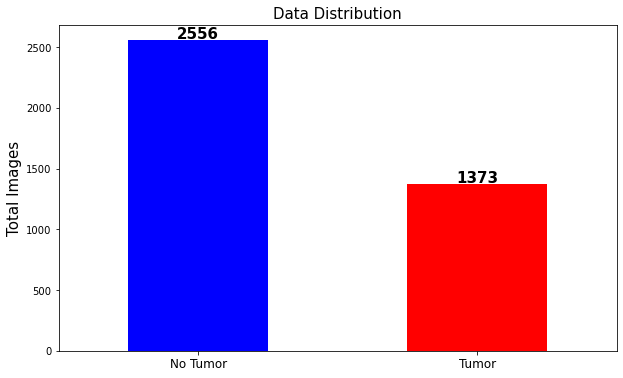

In [13]:
ax = PathDF['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(PathDF['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

Train, Val, Test Split

In [14]:
train2rest = Config.validation_fraction + Config.test_fraction
test2valid = Config.validation_fraction / train2rest

train_df, rest = train_test_split(PathDF, random_state=Config.seed,
                                 test_size = train2rest)

test_df, valid_df = train_test_split(rest, random_state=Config.seed,
                                    test_size = test2valid)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])
print('Test:', test_df.shape[0])

Train: 2946
Valid: 590
Test: 393


Visualization of images and masks

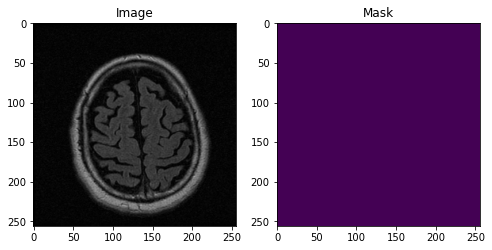

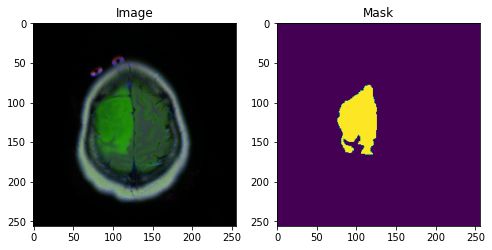

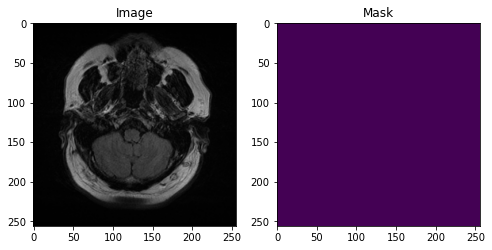

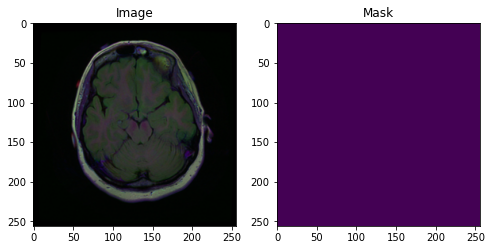

In [15]:
plot_example(0)
plot_example(5)
plot_example(10)
plot_example(20)

Dataset Class

In [16]:
class MRI_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform
        
    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        
        base_path = os.path.join(Config.data_dir, self.path_df.iloc[idx]['directory'])
        img_path = os.path.join(base_path, self.path_df.iloc[idx]['images'])
        mask_path = os.path.join(base_path, self.path_df.iloc[idx]['masks'])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        sample = (image, mask)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample        

Custom Transformations

In [17]:
class PairedRandomHorizontalFlip():
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        img, mask = sample
        if np.random.random() < self.p:
            img, mask = TF.hflip(img), TF.hflip(mask)
            
        return img, mask

In [18]:
class PairedRandomAffine():
    def __init__(self, degrees= None, translate=None, scale_ranges=None,
                shears=None):
        self.params = {
            'degree': degrees,
            'translate': translate,
            'scale_ranges':scale_ranges,
            'shears':shears
        }
    def __call__(self, sample):
        img, mask = sample
        w, h = img.size
        
        angle, translations, scale, shear = transforms.RandomAffine.get_params(
            self.params['degree'], self.params['translate'],
            self.params['scale_ranges'], self.params['shears'],
            (w,h)
        )
        
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        
        return img, mask

In [19]:
class PairedToTensor():
    def __call__(self, sample):
        img, mask = sample
        img = np.array(img)
        mask = np.expand_dims(mask, -1)
        img = np.moveaxis(img, -1, 0)
        mask = np.moveaxis(mask, -1, 0)
        img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
        img = img/255
        mask = mask/255
        return img, mask

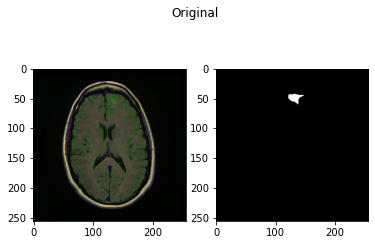

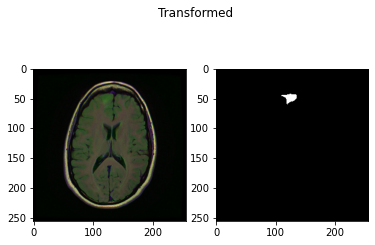

In [20]:
dataset = MRI_Dataset(test_df)
sample = dataset[59]
transform = PairedRandomHorizontalFlip(p=1)
show_sample(sample, title='Original')
show_sample(transform(sample), title="Transformed")

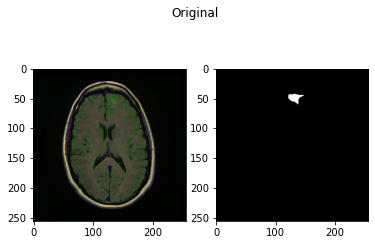

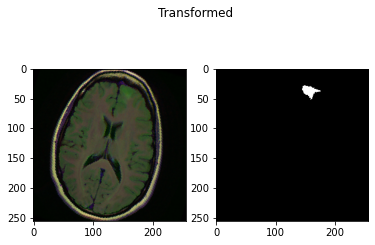

In [21]:
transform = PairedRandomAffine(
    degrees = (15,15),
    scale_ranges = (1.2, 1.2)
)
show_sample(sample, "Original")
show_sample(transform(sample), 'Transformed')

Data transformations and loaders

In [22]:
train_transforms = transforms.Compose(
    [PairedRandomHorizontalFlip(),
    PairedRandomAffine(
        degrees=(-15, 15),
        translate=(0.1, 0.1),
        scale_ranges=(0.8, 1.2)
    ),
    PairedToTensor()
    ])

eval_transforms = PairedToTensor()

train_data = MRI_Dataset(train_df, transform=train_transforms)
valid_data = MRI_Dataset(valid_df, transform=eval_transforms)
test_data = MRI_Dataset(test_df, transform=eval_transforms)

train_loader = DataLoader(train_data, batch_size=Config.train_batch,
                         shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=Config.valid_batch,
                         shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=Config.test_batch,
                        shuffle=False, num_workers=2)

Defining the Model

In [23]:
model = smp.Unet(    
    in_channels=Config.input_ch,                  
    classes=Config.output_ch,
    activation="sigmoid").to(Config.device)


Loss and metrics

In [24]:
# # code taken from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, logits=False, reduction=True):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.logits = logits
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         if self.logits:
#             BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
#         else:
#             BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-BCE_loss)
#         F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

#         if self.reduction:
#             return torch.mean(F_loss)
#         else:
#             return F_loss

In [25]:
# code taken from https://www.kaggle.com/code/lqdisme/brain-mri-segmentation-unet-pytorch/notebook

def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union


Training Loop

In [26]:
def train_loop(model, optimizer, criterion, train_loader,
              device=Config.device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    
    final_dice_coef = 0 
    
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item() * imgs.shape[0]
#         print(loss.item())
        
        out_cut = np.copy(out.detach().cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
        train_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
        final_dice_coef += train_dice 
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_loader.sampler)
    return {'dice coef':final_dice_coef/len(train_loader), 
                'loss':running_loss}

Evaluation Loop

In [27]:
def eval_loop(model, criterion, eval_loader, device=Config.device):
    
    running_loss = 0
    final_dice_coef = 0 
    
    model.eval()
    with torch.no_grad():

        pbar = tqdm(eval_loader, desc='Interating over evaluation data')
        
        for imgs, masks in pbar:
            
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item() * imgs.shape[0]
#             print(loss.item())
            
            out_cut = np.copy(out.detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            valid_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
            final_dice_coef += valid_dice 
            
    running_loss /= len(eval_loader.sampler)   
    return {
                'dice coef':final_dice_coef/len(eval_loader), 
                'loss':running_loss}

In [28]:
def train(model, optimizer, criterion, scheduler, train_loader, 
          valid_loader,device = Config.device,
          num_epochs = Config.epochs,
          valid_loss_min = np.inf):
    
    train_loss_list = []
    train_dice_coef = []
    val_loss_list = []
    val_dice_coef = []
    
    for e in range(num_epochs):
        
        train_metrics = train_loop(model, optimizer, criterion, 
                                   train_loader, device=device)
        
        val_metrics = eval_loop(model, criterion, valid_loader, device=device)
        
        scheduler.step(val_metrics['dice coef'])
        
        train_loss_list.append(train_metrics['loss']) 
        train_dice_coef.append(train_metrics['dice coef'])
        val_loss_list.append(val_metrics['loss'])
        val_dice_coef.append(val_metrics['dice coef'])
        
        print_string = f"Epoch: {e+1}\n"
        print_string += f"Train Loss: {train_metrics['loss']:.5f}\n"
        print_string += f"Train Dice Coef: {train_metrics['dice coef']:.5f}\n"
        print_string += f"Valid Loss: {val_metrics['loss']:.5f}\n"
        print_string += f"Valid Dice Coef: {val_metrics['dice coef']:.5f}\n"
        print(print_string)
        
        # save model
        if val_metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), "UNET.pt")
            valid_loss_min = val_metrics["loss"]
    return [train_loss_list,
    train_dice_coef,
    val_loss_list,
    val_dice_coef]

In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
criterion = nn.BCELoss(reduction='mean')
train_loss_list, train_dice_coef,val_loss_list,val_dice_coef = train(
    model, optimizer, criterion, scheduler, train_loader, valid_loader)

Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]/home/yasaisen/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.63it/s]


Epoch: 1
Train Loss: 0.04194
Train Dice Coef: 0.00549
Valid Loss: 0.03092
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.64it/s]


Epoch: 2
Train Loss: 0.02778
Train Dice Coef: 0.00000
Valid Loss: 0.03526
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.64it/s]


Epoch: 3
Train Loss: 0.02611
Train Dice Coef: 0.00268
Valid Loss: 0.03291
Valid Dice Coef: 0.47437



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.66it/s]


Epoch: 4
Train Loss: 0.02537
Train Dice Coef: 0.46041
Valid Loss: 0.02454
Valid Dice Coef: 0.52096



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.65it/s]


Epoch: 5
Train Loss: 0.02506
Train Dice Coef: 0.47244
Valid Loss: 0.02421
Valid Dice Coef: 0.61735



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.64it/s]


Epoch: 6
Train Loss: 0.02434
Train Dice Coef: 0.52054
Valid Loss: 0.02366
Valid Dice Coef: 0.56895



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.62it/s]


Epoch: 7
Train Loss: 0.02170
Train Dice Coef: 0.59677
Valid Loss: 0.02330
Valid Dice Coef: 0.59547



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.60it/s]


Epoch: 8
Train Loss: 0.02160
Train Dice Coef: 0.57715
Valid Loss: 0.03205
Valid Dice Coef: 0.31883



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.59it/s]


Epoch: 9
Train Loss: 0.02106
Train Dice Coef: 0.60198
Valid Loss: 0.01766
Valid Dice Coef: 0.68743



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.59it/s]


Epoch: 10
Train Loss: 0.01821
Train Dice Coef: 0.64759
Valid Loss: 0.01897
Valid Dice Coef: 0.65467



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.57it/s]


Epoch: 11
Train Loss: 0.01798
Train Dice Coef: 0.65178
Valid Loss: 0.01592
Valid Dice Coef: 0.73090



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.57it/s]


Epoch: 12
Train Loss: 0.01783
Train Dice Coef: 0.67049
Valid Loss: 0.01536
Valid Dice Coef: 0.75730



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.59it/s]


Epoch: 13
Train Loss: 0.01710
Train Dice Coef: 0.67628
Valid Loss: 0.01537
Valid Dice Coef: 0.69598



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.57it/s]


Epoch: 14
Train Loss: 0.01647
Train Dice Coef: 0.67739
Valid Loss: 0.01946
Valid Dice Coef: 0.59478



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch: 15
Train Loss: 0.01778
Train Dice Coef: 0.67066
Valid Loss: 0.01669
Valid Dice Coef: 0.66840



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch: 16
Train Loss: 0.01585
Train Dice Coef: 0.68567
Valid Loss: 0.01919
Valid Dice Coef: 0.60764



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch: 17
Train Loss: 0.01274
Train Dice Coef: 0.74026
Valid Loss: 0.01201
Valid Dice Coef: 0.78184



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch: 18
Train Loss: 0.01196
Train Dice Coef: 0.75465
Valid Loss: 0.01107
Valid Dice Coef: 0.79359



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch: 19
Train Loss: 0.01145
Train Dice Coef: 0.77341
Valid Loss: 0.01096
Valid Dice Coef: 0.78766



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch: 20
Train Loss: 0.01121
Train Dice Coef: 0.77246
Valid Loss: 0.01052
Valid Dice Coef: 0.80556



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch: 21
Train Loss: 0.01081
Train Dice Coef: 0.78707
Valid Loss: 0.01044
Valid Dice Coef: 0.82167



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch: 22
Train Loss: 0.01052
Train Dice Coef: 0.78348
Valid Loss: 0.01014
Valid Dice Coef: 0.81242



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.55it/s]


Epoch: 23
Train Loss: 0.01038
Train Dice Coef: 0.79064
Valid Loss: 0.01009
Valid Dice Coef: 0.80970



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.57it/s]


Epoch: 24
Train Loss: 0.01008
Train Dice Coef: 0.79077
Valid Loss: 0.00936
Valid Dice Coef: 0.83578



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.55it/s]


Epoch: 25
Train Loss: 0.00972
Train Dice Coef: 0.80068
Valid Loss: 0.00962
Valid Dice Coef: 0.82529



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch: 26
Train Loss: 0.00953
Train Dice Coef: 0.80180
Valid Loss: 0.00927
Valid Dice Coef: 0.82828



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch: 27
Train Loss: 0.00951
Train Dice Coef: 0.81207
Valid Loss: 0.00940
Valid Dice Coef: 0.82838



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.57it/s]


Epoch: 28
Train Loss: 0.00930
Train Dice Coef: 0.82007
Valid Loss: 0.00872
Valid Dice Coef: 0.84742



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch: 29
Train Loss: 0.00923
Train Dice Coef: 0.81977
Valid Loss: 0.00866
Valid Dice Coef: 0.84515



Interating over evaluation data: 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch: 30
Train Loss: 0.00932
Train Dice Coef: 0.81841
Valid Loss: 0.00860
Valid Dice Coef: 0.84156



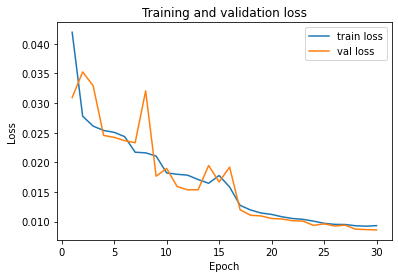

In [30]:
plt.plot(np.arange(1, Config.epochs + 1), train_loss_list, label="train loss")
plt.plot(np.arange(1, Config.epochs + 1), val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()

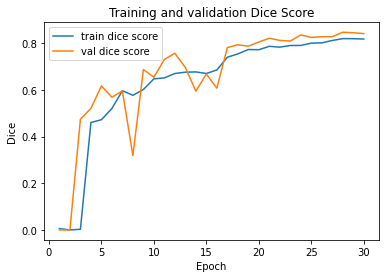

In [31]:
plt.plot(np.arange(1, Config.epochs + 1), train_dice_coef, label="train dice score")
plt.plot(np.arange(1, Config.epochs + 1), val_dice_coef, label="val dice score")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.title("Training and validation Dice Score")
plt.show()

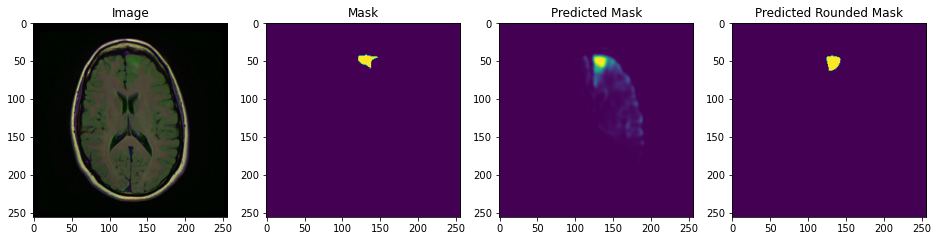

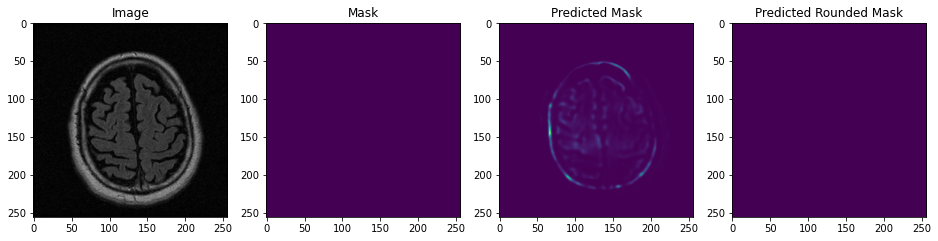

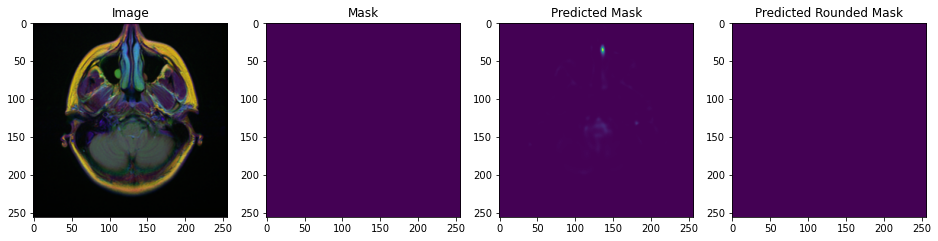

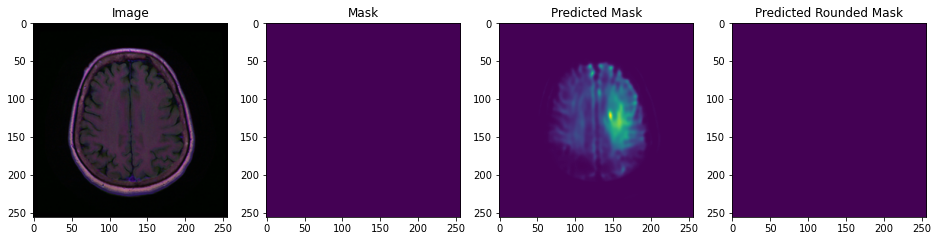

In [32]:
plot_predictions(model, 59)
plot_predictions(model, 0)
plot_predictions(model, 26)
plot_predictions(model, 3)

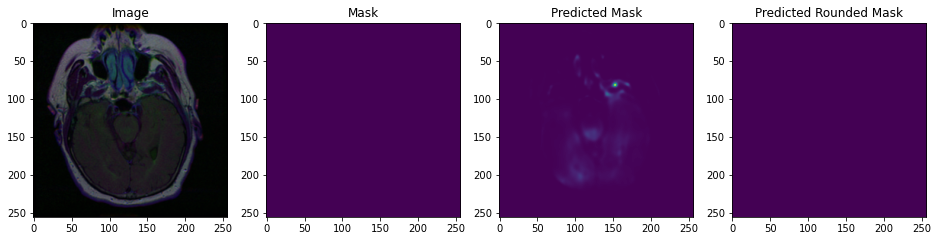

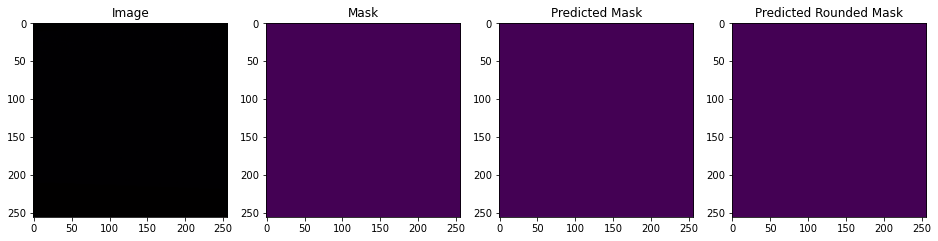

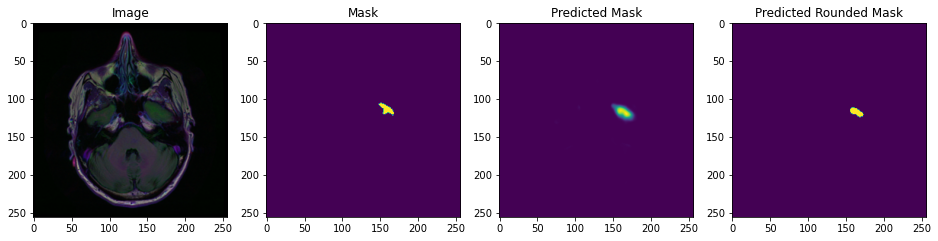

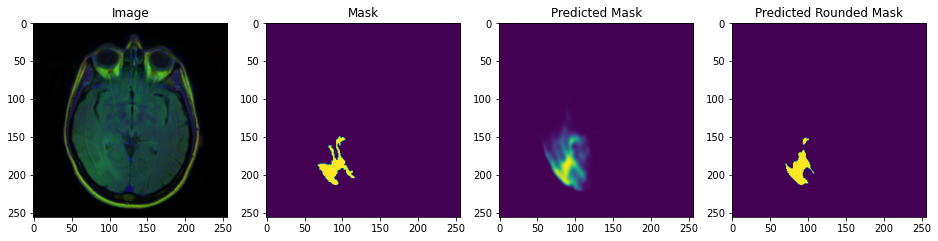

In [33]:
plot_predictions(model, 7)
plot_predictions(model, 31)
plot_predictions(model, 28)
plot_predictions(model, 1)

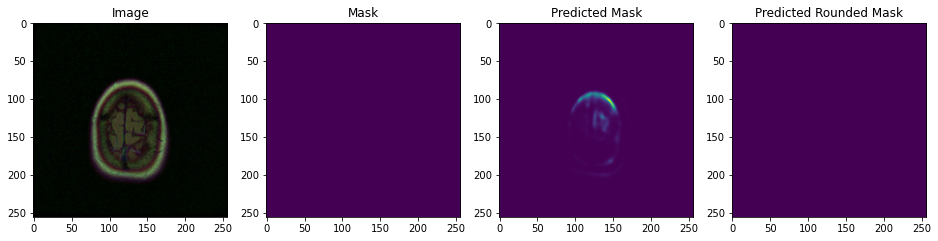

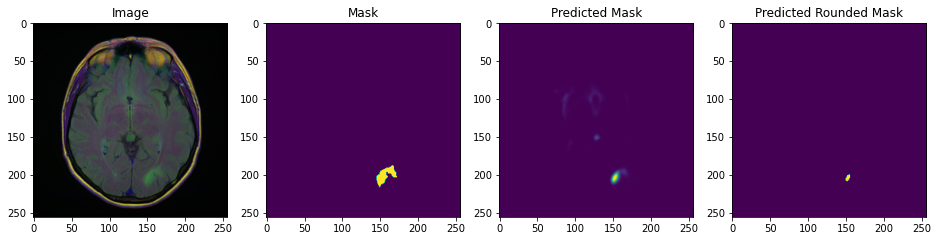

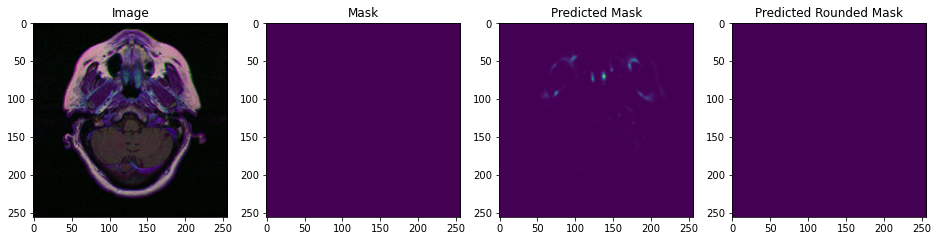

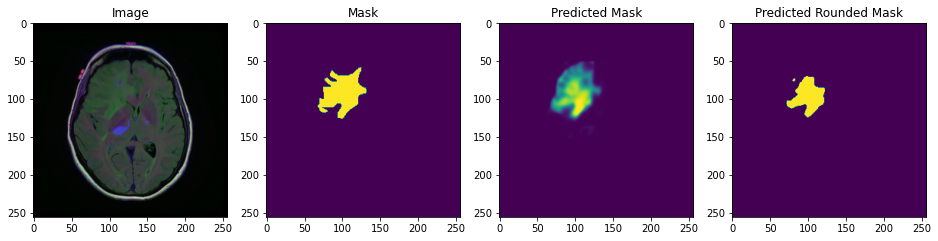

In [34]:
plot_predictions(model, 15)
plot_predictions(model, 19)
plot_predictions(model, 25)
plot_predictions(model, 73)

Heavily Inspired from https://www.kaggle.com/code/anastasiiaselezen/brain-mri-segmentation-pytorch